# iOS device sensors

- *Accelerometer* - indicates the instantaneous acceleration of the device in three dimensional space

- *Gyroscope* - indicatates the instantaneous rotation around the device's three primary axes

- *Magnetometer* - indicates the device's orientation relative to Earth's magnetic field

## Data sample example

In [1]:
!head -5 data_iphone_x/20191206_161846_1.txt

1,1575671757.529183,0.013062,-0.509857,-0.406815,0.119206,0.057954,-0.416490,26.258835,-32.553253,-170.973480
1,1575671757.539216,0.023483,-0.510574,-0.408905,0.045440,0.036428,-0.421204,26.628006,-32.639603,-170.687622
1,1575671757.549248,0.033401,-0.515900,-0.429352,-0.008224,-0.014894,-0.446239,26.701782,-32.571411,-170.772003
1,1575671757.559281,0.025345,-0.517944,-0.466064,-0.017717,-0.058564,-0.471437,27.080017,-32.891464,-170.404434
1,1575671757.569313,0.011124,-0.521149,-0.517227,0.005385,-0.020188,-0.412446,27.238525,-33.162476,-170.526062


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd

# 50Hz
freq = 50
data_dir = 'data_iphone_x'

columns = ['mode', 'timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z']

datasets_trunc = []
data_files = !ls {data_dir}
for file_name in data_files:
    file_path = os.path.join(data_dir, file_name)
    data = pd.read_csv(file_path, sep=',', header=None, names=columns)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data.set_index('timestamp', inplace=True)
    data = data[30*freq: -30*freq] # trip 30 sec, both ends
    datasets_trunc.append(data)
    print('loaded: %s \tlen: %d' % (file_path, len(data)))

loaded: data_iphone_x/20191206_161846_1.txt 	len: 17154
loaded: data_iphone_x/20191206_183744_0.txt 	len: 52025
loaded: data_iphone_x/20191206_200835_0.txt 	len: 57656
loaded: data_iphone_x/20191210_090940_1.txt 	len: 60890
loaded: data_iphone_x/20191210_092023_1.txt 	len: 57867
loaded: data_iphone_x/20191210_093035_0.txt 	len: 59362


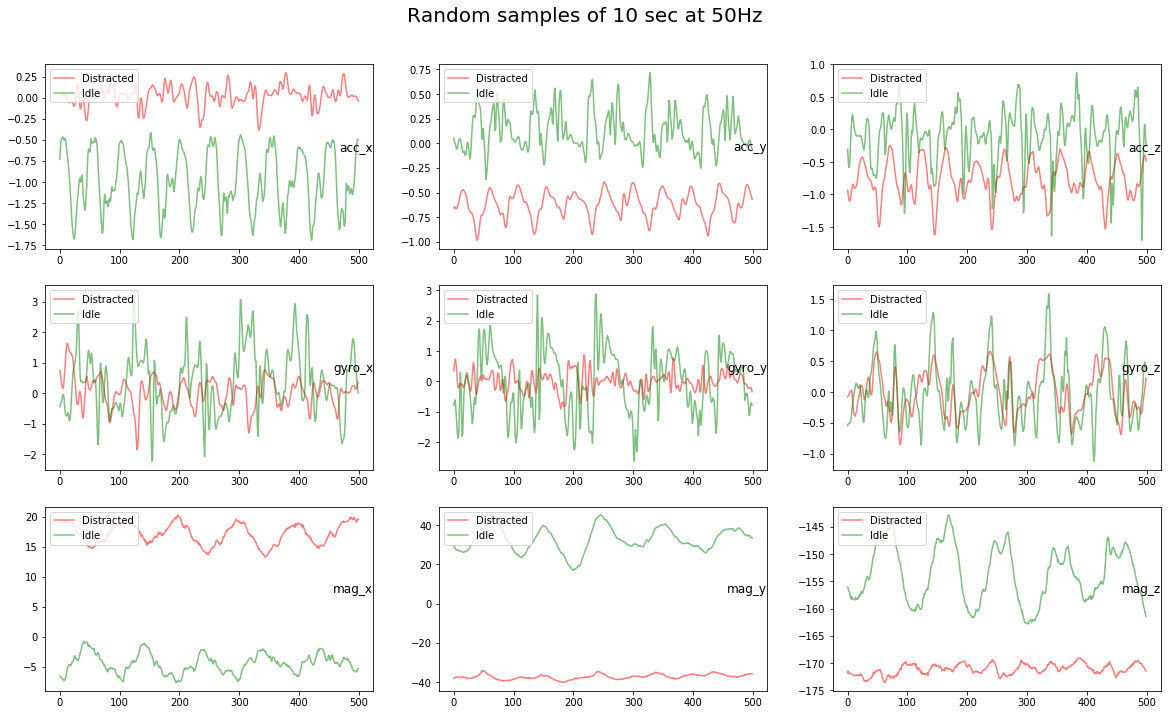

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

secs = 10 # plot 10 sec only

def plot_data(dfs):
    fdf = dfs[0]
    nrows = len(fdf.columns)
    cols = fdf.columns

    i = 1
    fig = plt.figure(figsize=(20, 40))
    title = "Random samples of %i sec at %iHz" % (secs, freq)
    fig.suptitle(title, fontsize=20, y=0.9)
    for row in range(1, nrows):
        plt.subplot(nrows, 3, i)
        for j in range(len(dfs)):
            values = dfs[j]
            begin = random.randint(0, len(values) - secs * freq)
            end = begin + secs * freq
            values = values.iloc[begin:end, :] 
            values = values.reset_index(drop=True)

            is_dist = values.iloc[0][0]
            label = "Distracted" if is_dist == 1 else "Idle"
            color = "red" if is_dist == 1 else "green"
            
            plt.plot(values.iloc[:, row], alpha=0.5, label=label, color=color)
            plt.legend(loc=2)
        plt.title(cols[row], y=0.5, loc='right')
        i += 1
    plt.show()

for i in range(0, 1):
    plot_data([datasets_trunc[0], datasets_trunc[1]])

In [5]:
def unroll_df(df, wind_size=128):
    mode = df.iloc[0]['mode'].astype(int)
    data = df.drop('mode', axis=1)
    unrld_data = []
    proc_len = 0
    while (proc_len + wind_size) < len(data):
        data_batch = data[proc_len:proc_len+wind_size]
        data_batch.reset_index(drop=True)
        values = data_batch.unstack(level=1).values
        unrld_data.append(values)
        proc_len += wind_size

    proc_data = pd.DataFrame(unrld_data)
    proc_data['label'] = mode
    proc_data.head()
    return proc_data

In [6]:
unrolled_datasets = []
for dataset in datasets_trunc:
    unrolled_datasets.append(unroll_df(dataset, wind_size=50))
    
dataset = pd.concat(unrolled_datasets, axis=0)

In [7]:
dataset.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,label
773,0.406036,-0.130936,-0.322342,-0.253510,0.008148,0.251831,0.442917,0.524567,0.388107,0.033234,...,-106.262222,-107.026184,-107.892960,-108.568314,-108.274109,-107.519760,-106.859329,-107.654877,-108.418976,0
305,0.291580,0.194351,0.133713,0.121857,0.148239,0.195816,0.272110,0.355347,0.402313,0.404190,...,-160.156448,-159.956360,-159.697144,-159.523468,-159.624496,-159.575409,-159.428848,-159.347794,-159.442001,1
98,-1.309906,-1.369232,-1.392456,-1.408051,-1.447083,-1.480240,-1.378922,-1.151672,-0.892990,-0.701309,...,-164.899094,-165.670074,-166.391663,-167.212906,-168.008377,-168.744858,-169.172195,-169.386246,-169.786972,0
294,-0.075928,-0.078720,-0.080612,-0.088379,-0.099747,-0.108139,-0.115631,-0.127457,-0.124115,-0.102448,...,-164.462311,-164.389206,-164.645889,-164.803116,-164.840805,-165.410736,-165.571564,-166.063568,-166.015167,1
214,-0.236603,-0.314621,-0.389252,-0.432938,-0.448517,-0.425842,-0.368378,-0.287598,-0.185349,-0.086304,...,-164.311462,-164.106812,-164.361725,-164.195282,-164.768814,-164.721252,-165.148468,-164.930603,-165.439026,1


## Preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from utils import *

In [9]:
X = dataset.drop('label', axis=1).values
Y = dataset['label'].values

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)

## Model

Using TensorFlow 1.13.1 and Keras 2.2.4 because CoreML converter doesn't currently have full support of TF 2.0 (RNN models)

In [11]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Activation, Reshape, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.
/Users/danylo_kostyshyn/workspace/activity-demo-model/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/danylo_kostyshyn/workspace/activity-demo-model/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/danylo_kostyshyn/workspace/activity-demo-model/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [12]:
def MyModel_LSTM():
    in_data = Input(shape=(50*9, ), dtype='float32')
    X = Reshape((50,9,), input_shape=(50*9,))(in_data)
    X = LSTM(50, return_sequences=True)(X)
    X = Dropout(0.5)(X)
    X = LSTM(50)(X)
    X = Dropout(0.5)(X)
    X = Dense(100, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=in_data, outputs=X)
    return model

# LSTM isnt supported on Android :(
def MyModel_FC():
    in_data = Input(shape=(50*9, ), dtype='float32')
    X = Dense(50, activation='relu')(in_data)
    X = Dropout(0.5)(X)
    X = Dense(50, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(20, activation='relu')(X)    
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=in_data, outputs=X)
    return model

In [ ]:
del model

In [13]:
model = MyModel_LSTM()
# model = MyModel_FC()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 9)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            12000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)  

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [15]:
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)
mc = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)

In [16]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, \
                    callbacks=[es, mc], validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 4938 samples, validate on 549 samples
Epoch 1/100
4938/4938 [==============================] - 6s 1ms/step - loss: 0.1599 - acc: 0.9585 - val_loss: 0.0091 - val_acc: 0.9945

Epoch 00001: val_acc improved from -inf to 0.99454, saving model to model.h5
Epoch 2/100
4938/4938 [==============================] - 5s 916us/step - loss: 0.0142 - acc: 0.9959 - val_loss: 7.2124e-04 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.99454 to 1.00000, saving model to model.h5
Epoch 3/100
4938/4938 [==============================] - 5s 985us/step - loss: 0.0026 - acc: 0.9992 - val_loss: 1.8778e-04 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/100
4938/4938 [==============================] - 5s 965us/step - loss: 0.0042 - acc: 0.9990 - val_loss: 6.3462e-04 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/100
4938/4938 [==============================] - 5s 1ms/step - loss: 0.0026 - 

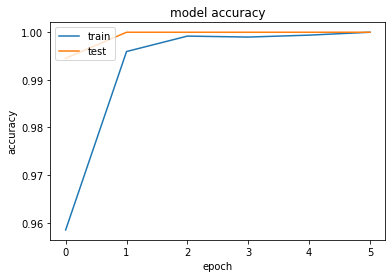

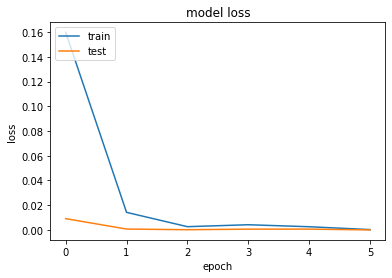

In [17]:
plot_model_accuracy(history)
plot_model_loss(history)

In [18]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test loss = ", loss)
print("Test accuracy = ", acc)

610/610 [==============================] - 0s 335us/step
Test loss =  2.248257689166539e-05
Test accuracy =  1.0


In [ ]:
del model

model = load_model('model.h5')
model.summary()

In [ ]:
# brew install GraphViz
from keras.utils import plot_model
plot_model(model)

## CoreML converter

In [19]:
!./converter.py \
        --model model.h5 \
        --desc "Predicts either a phone is in the hands or in a pocket" \
        --input_desc "Sensor samples (acc, gyro, mag, 50Hz)" \
        --output_desc "1 - phone in the hands, 0 - phone in a pocket" \
        --author "Danylo Kostyshyn" \
        --license="MIT"

/Users/danylo_kostyshyn/workspace/activity-demo-model/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/danylo_kostyshyn/workspace/activity-demo-model/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/danylo_kostyshyn/workspace/activity-demo-model/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

## TensorFlow Lite model

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model_file('model.h5')
tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)